# Proof of concept: Training a structured, recurrent, delayed, long-term plastic SNN

From here on out, we're going to start *very* simple, and build up within this file. No more proliferation of parts.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

import time

In [2]:
dtype = torch.float
device = torch.device("cuda:0") 

In [3]:
time_step = 1e-3
n_steps  = 500

In [4]:
def decayconst_tensor(dt, framework = torch):
    return lambda tau: framework.exp(-dt/tau)

def decayconst(tau):
    return float(np.exp(-time_step/tau))

def sigmoid_project(value, bounds, framework = torch):
    return bounds[0] + (bounds[1]-bounds[0])/(1 + framework.exp(-value))

In [5]:
cortex_params = {
    'batch_size': 256,
    'n_inputs': 20,
    'n_outputs': 1,
    
    'weight_scale': 0.5, # initial weights are drawn from N(0, weight_scale/sqrt(num))
    
    'tau_mem': 20e-3,                # Membrane time constant
    'tau_mem_out': 20e-3,            # Readout membrane tau
    
    'populations': [
        {'name': 'E0', 'n': 4, 'sign': 1},
        {'name': 'I0', 'n': 4, 'sign': -1},
    ]
}
cortex_params['weight_scale'] = 7*(1.0-decayconst(cortex_params['tau_mem']))

batch_size = cortex_params['batch_size']
n_inputs   = cortex_params['n_inputs']
n_outputs  = cortex_params['n_outputs']

In [6]:
class SurrGradSpike(torch.autograd.Function):
    scale = 100.0

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

In [7]:
class Cortex(nn.Module):
    def __init__(self, pars):
        super(Cortex, self).__init__()
        self.pars = pars
        
        # Network structure
        nested_signs = [[p['sign']] * p['n'] for p in pars['populations']]
        flat_signs = [i for part in nested_signs for i in part]
        self.w_signs = torch.tensor(flat_signs, device=device, dtype=dtype).diag()
        N = len(flat_signs)
        self.N = N
        
        
        # Weights
        w_in = torch.empty((pars['n_inputs'], N),  device=device, dtype=dtype)
        torch.nn.init.normal_(w_in, mean=0.0, std=pars['weight_scale']/np.sqrt(pars['n_inputs']))
        self.w_in = torch.nn.Parameter(w_in) # LEARN

        w = torch.empty((N, N), device=device, dtype=dtype)
        torch.nn.init.normal_(w, mean=0.0, std=pars['weight_scale']/np.sqrt(N))
        self.w = torch.nn.Parameter(w) # LEARN

        w_out = torch.empty((N, pars['n_outputs']), device=device, dtype=dtype)
        torch.nn.init.normal_(w_out, mean=0.0, std=pars['weight_scale']/np.sqrt(N))
        self.w_out = torch.nn.Parameter(w_out) # LEARN
        
        
        # Membrane time constants
        self.alpha_mem = decayconst(pars['tau_mem'])
        self.alpha_mem_out = decayconst(pars['tau_mem_out'])
        
    def forward(self, inputs):
        bs = self.pars['batch_size']
        
        # Compute the input currents
        h1 = torch.einsum("abc,cd->abd", (inputs, self.w_in))

        # Zero-initialise state variables
        mem = torch.zeros((bs,self.N), device=device, dtype=dtype)
        out = torch.zeros((bs,self.N), device=device, dtype=dtype)

        # Add Dale's Law signs to recurrent weights
        rec_weights = torch.matmul(self.w_signs, torch.abs(self.w))

        # Lists to collect states
        mem_rec = []
        spk_rec = []

        # Compute hidden layer activity
        for t in range(n_steps):
            # Mark spikes
            mthr = mem-1.0
            out = SurrGradSpike.apply(mthr)
            rst = torch.zeros_like(mem)
            rst[mthr > 0] = 1.0

            # Record
            mem_rec.append(mem)
            spk_rec.append(out)
            
            # Integrate
            mem = self.alpha_mem*mem +h1[:,t] +torch.einsum('bi,ij->bj', (out, rec_weights)) -rst

        # Recordings
        self.mem_rec = torch.stack(mem_rec,dim=1)
        self.spk_rec = torch.stack(spk_rec,dim=1)

        # Readout layer
        h2 = torch.einsum("abc,cd->abd", (self.spk_rec, self.w_out))
        out = torch.zeros((bs,self.pars['n_outputs']), device=device, dtype=dtype)
        out_rec = []
        for t in range(n_steps):
            out = self.alpha_mem_out*out +h2[:,t]
            out_rec.append(out)

        out_rec = torch.stack(out_rec,dim=1)
        return out_rec

### Input
The basic task is one of prediction: I want the network to tell me what the input signal will look like in a short while.

In [8]:
n_freqs = 2
max_freq = 25 # Hz, oscillator frequency
max_rate = 100 # Hz, firing frequency

In [9]:
freqs = torch.abs(torch.randn((1,1,n_freqs,1))) * max_freq
phases = torch.rand((1,1,n_freqs,1))

times = torch.arange(n_steps).reshape(1,-1,1,1) * time_step
raw_rates = torch.sin(2*np.pi*(freqs * times + phases)) * .5 + .5

y_data = (torch.sum(raw_rates, 2)/n_freqs).to(device=device, dtype=dtype).expand(batch_size,n_steps,n_outputs)

samplings = torch.rand((batch_size,1,n_freqs,n_inputs))
rates = torch.sum(raw_rates * samplings, 2)/n_freqs

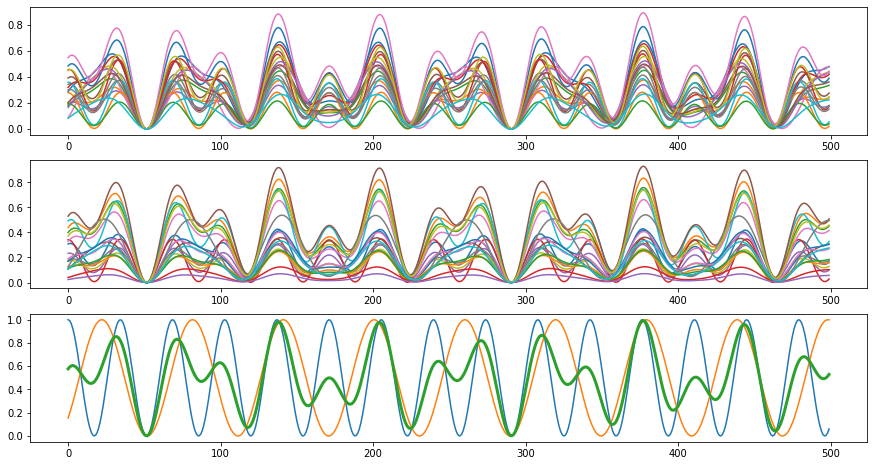

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(311)
plt.plot(rates[0].numpy())
plt.subplot(312)
plt.plot(rates[1].numpy())

plt.subplot(313)
plt.plot(raw_rates[0,:,:,0].numpy())
plt.plot(y_data[0].cpu().numpy(), lw=3);

In [11]:
prob = rates.to(device)*time_step*max_rate
mask = torch.rand((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data[mask<prob] = 1.0

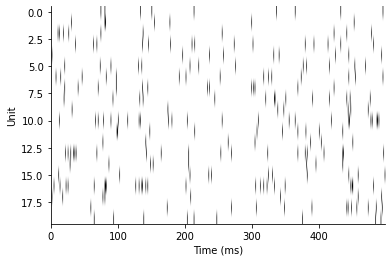

In [12]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Define a helper function to visualise activity:

In [13]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5, ax=None):
    if type(ax) == type(None):
        _,ax = plt.subplots(*dim, sharey=True)
    ax = ax.flatten()
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        ax[i].plot(dat[i])
        ax[i].axis("off")
    return ax

In [14]:
model = Cortex(cortex_params)
output = model(x_data)

<Figure size 600x400 with 0 Axes>

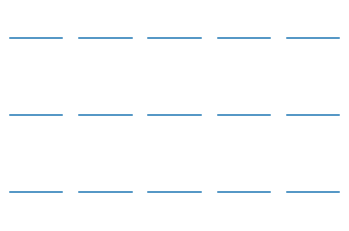

In [15]:
fig=plt.figure(dpi=100)
ax = plot_voltage_traces(output)

In [16]:
loss_fn = torch.nn.MSELoss()
print("Mean squared error: %.3f" % loss_fn(output, y_data))

Mean squared error: 0.313


Let's add a function to inspect the gradients:

In [17]:
from matplotlib.lines import Line2D
def get_grad_plotter(alpha = 0.1, top = 0.02):
    def plot_grads(named_parameters, ax):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if p.requires_grad:
                grad = p.grad.abs()
                ave_grads.append(grad.mean())
                max_grads.append(grad.max())
                layers.append(n)
        ax.bar(np.arange(len(max_grads))+.4, max_grads, alpha=alpha, width=.4, color="c")
        ax.bar(np.arange(len(max_grads)), ave_grads, alpha=alpha, width=.4, color="b")
        ax.xaxis.set_ticks(range(0,len(ave_grads), 1))
        ax.xaxis.set_ticklabels(layers, rotation="vertical")
        ax.set_ylim(top=top)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Gradient")
        ax.grid(True)
        ax.legend([Line2D([0], [0], color="c", lw=4),
                   Line2D([0], [0], color="b", lw=4)], ['max-gradient', 'mean-gradient'])
        sns.despine(offset=4)
    return plot_grads

I have no idea whether this will train! Let's try.

Forward, backward, overhead: 0.161 s; 0.142 s; 0.006 s
Forward, backward, overhead: 0.165 s; 0.144 s; 0.002 s
Forward, backward, overhead: 0.174 s; 0.146 s; 0.003 s
Forward, backward, overhead: 0.172 s; 0.142 s; 0.004 s
Forward, backward, overhead: 0.174 s; 0.143 s; 0.002 s
Forward, backward, overhead: 0.176 s; 0.144 s; 0.003 s
Forward, backward, overhead: 0.173 s; 0.147 s; 0.002 s
Forward, backward, overhead: 0.174 s; 0.147 s; 0.002 s
Forward, backward, overhead: 0.176 s; 0.150 s; 0.004 s


<ipython-input-13-2b749f96f2ba>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _,ax = plt.subplots(*dim, sharey=True)


Forward, backward, overhead: 0.180 s; 0.153 s; 0.002 s


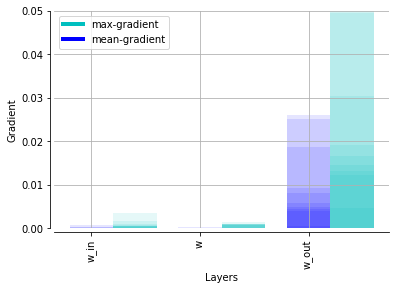

<Figure size 600x400 with 0 Axes>

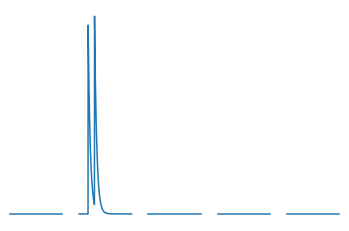

<Figure size 600x400 with 0 Axes>

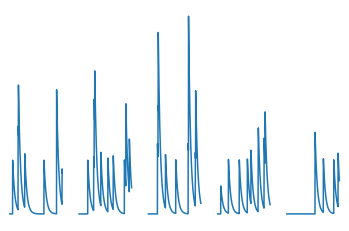

<Figure size 600x400 with 0 Axes>

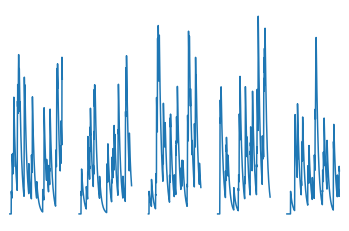

<Figure size 600x400 with 0 Axes>

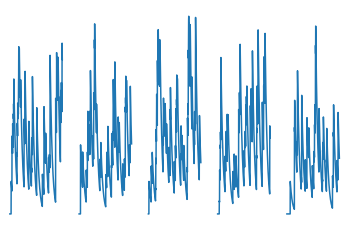

<Figure size 600x400 with 0 Axes>

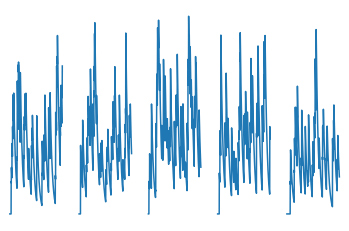

<Figure size 600x400 with 0 Axes>

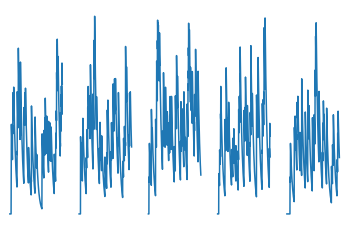

<Figure size 600x400 with 0 Axes>

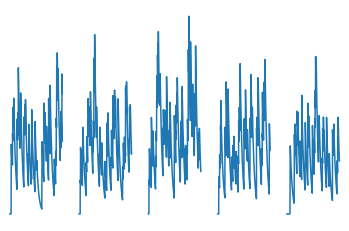

<Figure size 600x400 with 0 Axes>

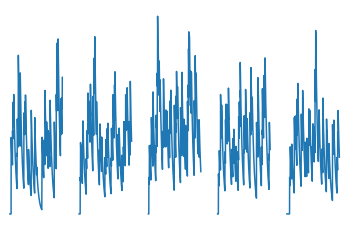

<Figure size 600x400 with 0 Axes>

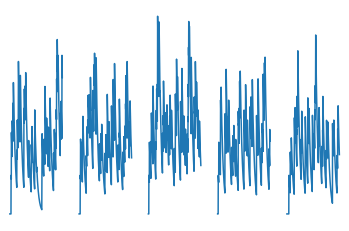

<Figure size 600x400 with 0 Axes>

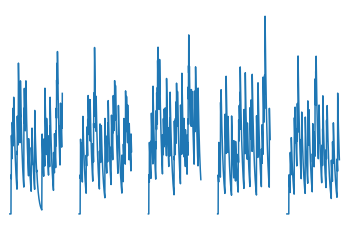

In [18]:
model = Cortex(cortex_params)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

epochs, reporting_interval = 200, 20
t_forward = t_backward = overhead = 0
tic = time.perf_counter()

ax = plt.figure().subplots()
plot_grad = get_grad_plotter(top=.05)

# The optimization loop
loss_hist = []
for e in range(epochs):
    # run the network and get output
    overhead += time.perf_counter() - tic
    tic = time.perf_counter()
    
    output = model(x_data)
    
    toc = time.perf_counter()
    t_forward += toc-tic
    
    # compute the loss
    loss_val = loss_fn(output, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    tic = time.perf_counter()
    t_backward += tic-toc
    
    # store loss value
    loss_hist.append(loss_val.item())
    
    if e%reporting_interval == 0:
        plot_grad(model.named_parameters(), ax)
        fig=plt.figure(dpi=100)
        plot_voltage_traces(output,dim=(1,5))
        if e > 0:
            t_forward /= reporting_interval
            t_backward /= reporting_interval
            overhead /= reporting_interval
        print("Forward, backward, overhead: %0.3f s; %0.3f s; %0.3f s" % (t_forward, t_backward, overhead))
        t_forward = t_backward = overhead = 0

0.09119421988725662


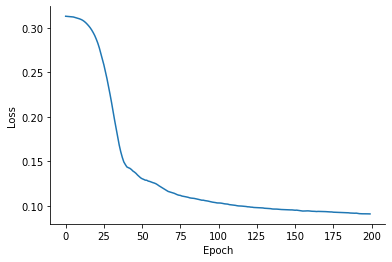

In [19]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()
print(loss_hist[-1])

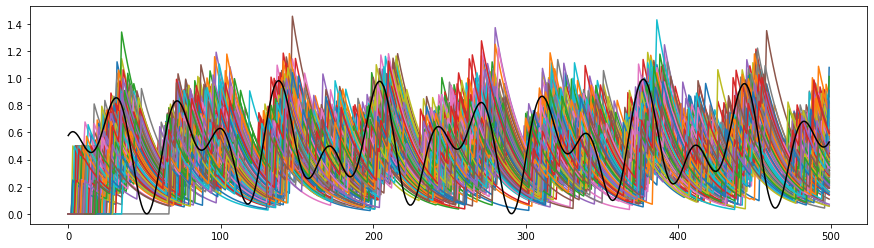

In [20]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,0].detach().cpu().numpy().T)
plt.plot(y_data[0,:,0].cpu().numpy(), color='black');

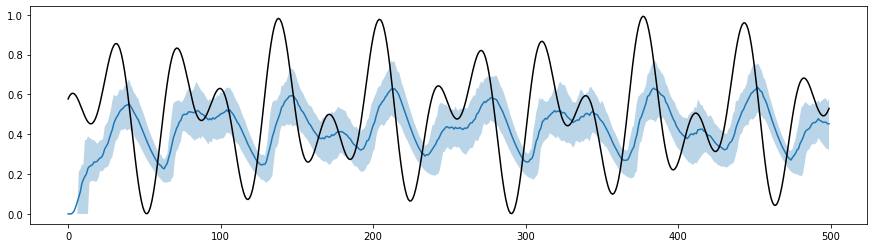

In [27]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,0].detach().mean(dim=0).cpu().numpy().T)
lo,hi = [torch.quantile(output[:,:,0].detach(), q, dim=0).cpu().numpy() for q in (.25,.75)]
plt.fill_between(np.arange(len(lo)), lo, hi, alpha=.3)
plt.plot(y_data[0,:,0].cpu().numpy(), color='black');

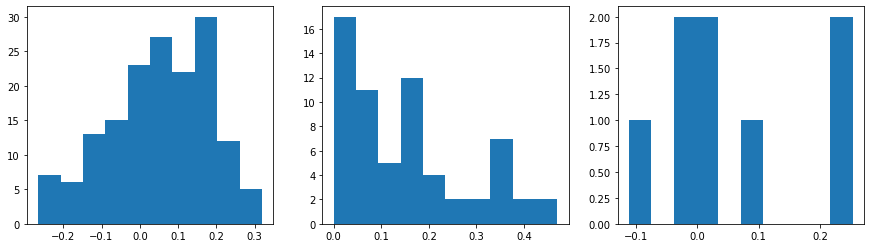

In [26]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.hist(model.w_in.detach().cpu().numpy().flat)
plt.subplot(132)
plt.hist(model.w.detach().abs().cpu().numpy().flat)
plt.subplot(133)
plt.hist(model.w_out.detach().cpu().numpy().flat);